# Feature Engineering

Feature engineering is done on 3 main key drivers
    1) Growth of POC
    
    2) Product Profitability
    
    3) Customer Loyalty & Relationships
    
    
1) Growth of POC
    
    Following factors are considered 
        
        a. Past Growth of POC
        
        b. Industry Growth
        
        c. Market Capitalisation
    
    Based on this factors , we come up with appropriate features
    
    Market for a POC is defined as combination of segment , sub_segment , sdfc_tier , poc_image , province
    
    Past POC growth refers to the change in volume from 2018 to 2019
    
    Industry growth is defined as the mean growth of all the POC's in that market
    
    Market Capitalisation is define by the percentage of Volume ordered by POC to the total Volume ordered by all POC's in that market in 2019
    
    Based on this factors , we come up with appropriate features
        
         a. Future Growth : (Past Growth of POC + (market cap * industry growth))/(1 + market cap)
         
         b. Expected GTO : GTO that is expected from the POC in next financial year
                 
                      =  GTO_2019 * ((Volume_2019 + future gowth)/Volume_2019)
                      
         c. Expected Product Volume : Product Volume expected from the POC in next financial year
         
                      =   Volume_2019 Product * ((Volume_2019 + future gowth)/Volume_2019)
       

2) Product Profitability :
    
    a. Order Size : Volume of Product set ordered by given POC over the Product Set total volume ordered by all the POC's
    
    b. minimum order size for discount : The minimum order size of a particular product set that must be ordered in order to qualify for discounts
    
    c. Profitability Indicator of a Product : Mean discount given on a product Set / Maximum mean discount on any product set
    
    d. Profit Margin : (Average Discount given on a product set / Average GTO of a product set) * 1.5
    
    e. Inventory Lingering Factor : Gives an idea of whether we have a lot of stock of a particular product in our inventory
    
        = (Maximum Discount on Product Set / Maximum Discount on any Product Set) * (how much order_size is above min order size for discount in scaled terms)
          
          
3) Customer Loyalty & Relationships :
    
     a. Loyalty Index : Depends on market capitalisation & order size
     
4) Upper Limit for Discounts :

    Considers both Growth of POC and Product Profitability (Profit Margin) into considerations
    
    Upper Limit =  (Average Discount on Product Set * (GTO of POC for that Product / Average GTO for Product)) * (Expected GTO / Current GTO) * 1.2
    
    
    Term 1 : Product Profitability factor    Term 2 : Growth of POC 	1.2 : Scaling factor


    Upper Limit defines maximum total discount that can be given to POC such that company is profitable
    
    Upper limit is used to find out the data where discounts are given correctly and ones where correction is required

In [1]:

def featureEngineering(df):
    '''
    Feature Engineering Code used to arrive at data2.xlsx : Addition of new columns
    
    Market for POC : Combination of segment , sub_segment , sdfc_tier, poc_image, province
    '''
    df['growth_past'] = ((df['Volume_2019'] - df['Volume_2018']))
    df['industry_growth'] = [np.mean(df.loc[(df['segment']==df['segment'][i])  & (df['poc_image']==df['poc_image'][i]) & (df['sfdc_tier'] == df['sfdc_tier'][i]) & (df['sub_segment']==df['sub_segment'][i]) & (df['province']==df['province'][i]) , "growth_past" ]) for i in range(len(df['growth_past']))]
    df['market_cap'] = [df['Volume_2019'][i]/(np.sum(df.loc[  (df['segment'] == df['segment'][i]) & (df['sub_segment']==df['sub_segment'][i]) & (df['poc_image']==df['poc_image'][i]) & (df['province']==df['province'][i]) & (df['sfdc_tier']==df['sfdc_tier'][i]) , "Volume_2019"] )) for i in range(len(df['industry_growth']))]
    df['market_cap'] = df['market_cap'].fillna(0)
    
    '''
    Here we are predicting the future growth of a POC
    Future Growth = (growth_past + market_cap * industry_growth)/(1 + market_cap)
    
    '''
    
    df['future_growth'] = [(df['growth_past'][i] + df['market_cap'][i]*df['industry_growth'][i])/(1+df['market_cap'][i]) for i in range(len(df['industry_growth']))]
    
    '''
    Here we are trying to find the order_size of a product set given by POC as compared to max order given for that product by any POC
    
    '''
    df['order_size'] = [df['Volume_2019 Product'][i]/(np.amax(df.loc[df['Product Set']==df['Product Set'][i] , "Volume_2019 Product"])) for i in range(len(df['growth_past']))]
    
    '''
    Computing the expected GTO & Volume
    '''
    val = df['GTO_2019'] * ((df['Volume_2019'] + df['future_growth'])/(df['Volume_2019']+0.01))
    df['Expected_GTO'] = val
    df['Expected_product_volume'] = df['Volume_2019 Product']*((df['Volume_2019'] + df['future_growth'])/(df['Volume_2019']+0.01))
    
    df['loyalty_index'] = 0
    for i in range(len(df['growth_past'])):
        if((df['market_cap'][i]>0.02) & (df['order_size'][i]>0.02)):
            df['loyalty_index'][i] = 1
        
        
    df['min_order_size_for_discount'] = [np.amin(df.loc[(df['Product Set'] == df['Product Set'][i]) & (df['Discount_Total']>0) & (df['order_size']>0) , "order_size"]) for i in range(len(df['growth_past']))]
    '''
    Inventory lingering factor based on product discount over max discount & how much order size is above the minimum order size
    
    '''
    df['inventory_lingering_factor'] = [(np.amax(df.loc[df['Product Set'] == df['Product Set'][i] , "Discount_Total"])/(np.amax(df['Discount_Total'])+0.01)) * ((df['order_size'][i] - df['min_order_size_for_discount'][i])/(df['order_size'][i] + 0.01))*100  for i in range(len(df['growth_past'])) ]

    df['inventory_lingering_factor'] = df['inventory_lingering_factor'].fillna(0)
    df['min_order_size_for_discount'] = df['min_order_size_for_discount'].fillna(0)
    
    '''
    Profitability Indicator : Gives an idea of how Profitable a particular product is for ABInBev
    '''
    df['profit_Product'] = [np.mean(df.loc[ df['Product Set']==df['Product Set'][i] , "Discount_Total"]) for i in range(len(df['growth_past']))]
    maxDiscount = np.amax(df['profit_Product'])
    df['profitability_indicator'] = [(df['profit_Product'][i]/maxDiscount)*100 for i in range(len(df['growth_past']))]
    
    '''
    Upper Limit for Discount : Here we try to compute upper limit for discount , considers order size , product profitabilty , POC Growth , Expected GTO
    
    '''
    GTO = [np.mean(df.loc[ df['Product Set']==df['Product Set'][i] , "GTO_2019"]) for i in range(len(df['growth_past']))]
    n = len(df['growth_past'])
    pqr = [0 for i in range(n)]
    xyz = [0 for i in range(n)]
    a = df['order_size']
    b = df['min_order_size_for_discount']
    c = df['profit_Product']

    d = df['Expected_GTO']
    e = df['GTO_2019']
    f = df['Volume_2019 Product']
    '''
    Upper Limit for discount = ((Avg Discount for the Product Set* (GTO of POC for that Product/Average GTO of product)) * ( Expected GTO/Current GTO))*1.2
    1st term considers product level parameters
    2nd term specifies growth of the POC
    Multiplying it by 1.2 to set the upper limit for discounts
    '''
    for i in range(len(df['growth_past'])):
        
    
        xyz[i] = c[i]*(e[i]/(GTO[i]+0.01))*(d[i]/(e[i]+0.01))*1.2
    df['upper_limit'] = xyz
    
    return df





import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
# data2.xlsx is the data obtained after running the feature engineering code
# data3.csv : converted data2.xlsx to data3.csv because of easiness of use of csv files in webapps
path = r"C:\Users\NISARG\Desktop\mech\Finance\Maverick\CODE"   #change the path to your local path
df = pd.read_csv(path + "\data3.csv")
df.head()


,Unnamed: 0,Unnamed: 0.1,Ship-to ID,Volume_2019,Volume_2018,sdfc_Tier,poc_image,segment,sub_segment,Product Set,...,Expected_GTO,Expected_product_volume,loyalty_index,min_order_size_for_discount,inventory_lingering_factor,profit_Product,profitability_indicator,discount_std,upper_limit,Disc_Percent
0,0,0,29000310,0.48,0.557,Tier 0,Mainstream,Entertainment Led,Events,RETURNABLE_BOTTLE_JUPILER_JUPILER PILS,...,116.362876,0.395568,0,0.000059,0.030049,370.415207,0.474992,840.354946,30.119944,0.000000
1,1,1,29000419,0.45,0.540,Tier 1,Mainstream,Not applicable,Not applicable,RETURNABLE_BOTTLE_PIEDBOEUF_PIEDBOEUF TRIPLE,...,88.943478,0.352174,0,0.002273,0.057372,207.180476,0.265672,421.813020,21.621963,0.000000
2,2,2,29000430,270.97,225.720,Tier 1,Mainstream,Drink Led,Party Place,OW_BULK_JUPILER_JUPILER PILS,...,71342.136430,276.519909,1,0.000768,60.857752,77983.465190,100.000000,188693.263300,39604.153890,0.235763
3,3,3,29000430,270.97,225.720,Tier 1,Mainstream,Drink Led,Party Place,RETURNABLE_BOTTLE_JUPILER_JUPILER PILS,...,6955.593627,23.645077,1,0.000059,0.507591,370.415207,0.474992,840.354946,1800.544853,0.267487
4,4,4,29000430,270.97,225.720,Tier 1,Mainstream,Drink Led,Party Place,RETURNABLE_KEG_JUPILER_JUPILER PILS,...,3536.747237,13.908869,0,0.000064,5.144873,3160.708348,4.053049,11271.537870,948.335453,0.235409


In [9]:
categorical_vars = ['sfdc_tier','poc_image','Returnalility']

# Highly Skewed Distribution

As seen in the plots below , distributions for Discount & GTO are highly skewed

This gives us an indication that we should divide the dataset before modelling discounts 

count    3.985900e+04
mean     6.190571e+02
std      1.050909e+04
min     -2.087009e+04
25%      6.540000e+00
50%      3.370000e+01
75%      1.422400e+02
max      1.260856e+06
Name: Discount_Total, dtype: float64


C:\Users\NISARG\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


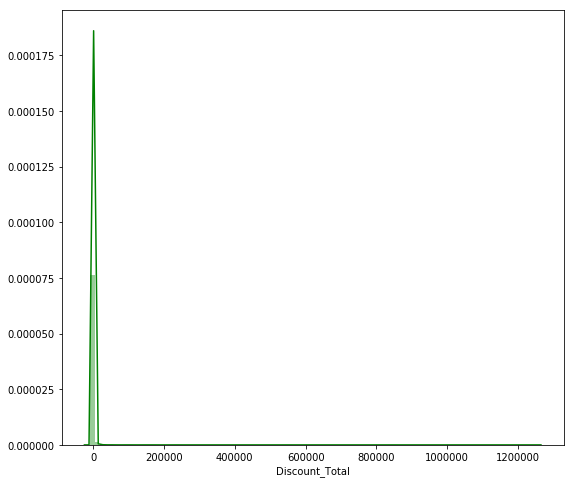

In [10]:
print(df['Discount_Total'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['Discount_Total'], color='g', bins=100, hist_kws={'alpha': 0.4});

count    3.985900e+04
mean     2.329499e+03
std      2.183562e+04
min     -1.625964e+04
25%      7.712000e+01
50%      2.234700e+02
75%      7.992400e+02
max      2.727988e+06
Name: GTO_2019, dtype: float64


C:\Users\NISARG\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


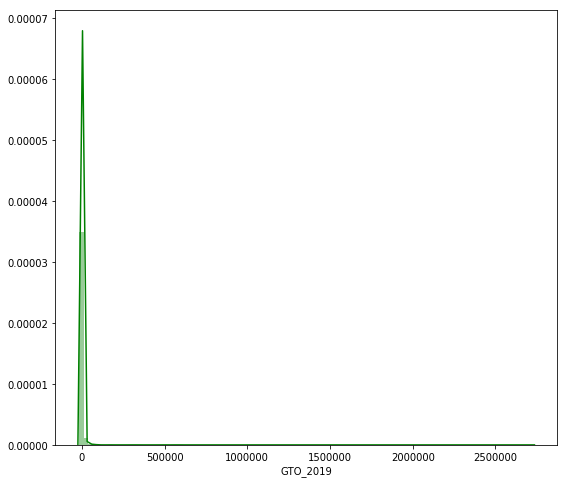

In [11]:
print(df['GTO_2019'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['GTO_2019'], color='g', bins=100, hist_kws={'alpha': 0.4});

# EDA Comments:-
    1) 99.88% of discounts are in range (0,10,000)
    
    2) GTO_2019 follows almost the same distribution as Total_Discount and is highly correlated with it
    
    3) Seperate Modelling for GTO above 50,000 & GTO below 50,000 because if done in 1 model , they will go as outliers
    
    4) LessGTOData , Dominant Numeric Features : GTO_2019 , OnInvoice , OffInvoice , Tax , Volume_2019 Product , Expected GTO, Expected Volume_prod , order_size , profitability_indicator , upper_limit
    
    5) HighGTOData , Dominant Numeric Features : Volume_2018 , Volume_2019 , OffInvoice Discount , Tax, GTO_2019, Expected GTO , Volume_Product , profitability_indicator , upper_limit
    
    6) LessGTOData , Dominant Categorical Features : sdfc_tier, poc_image , returnalility , loyalty_index
    
    7) HighGTOData , Dominant Categorical Features : None


C:\Users\NISARG\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


0.0051933064050779


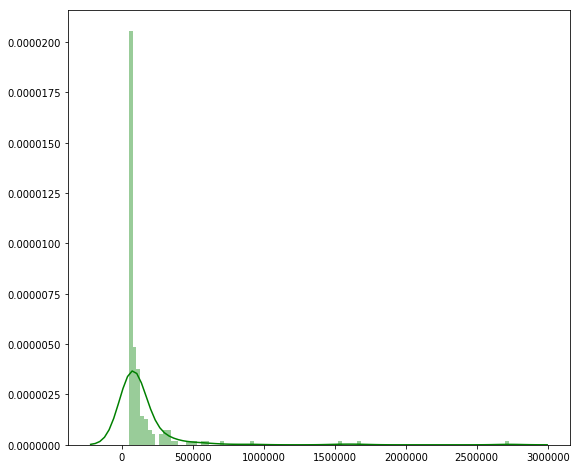

In [12]:
'''
Visualizing GTO>50k data
'''
val = list()
for i in range(len(df['GTO_2019'])):
    if(df['GTO_2019'][i]>50000):
        val.append(df['GTO_2019'][i])
plt.figure(figsize=(9, 8))
sns.distplot(val, color='g', bins=100, hist_kws={'alpha': 0.4});
print(len(val)/len(df['GTO_2019']))

In [13]:
'''
Dividing the data for better analysis
'''
data2 = df[df.GTO_2019>50000]
data2 = data2.reset_index()
data2 = data2.drop(["index"],axis=1)

In [14]:
data2_num =  data2.select_dtypes(include = ['float64', 'int64'])
data2_num.head()

,Unnamed: 0,Unnamed: 0.1,Ship-to ID,Volume_2019,Volume_2018,GTO_2019,OnInvoice Discount(LCU),OffInvoice Discount(LCU),Volume_2019 Product,Tax,...,Expected_GTO,Expected_product_volume,loyalty_index,min_order_size_for_discount,inventory_lingering_factor,profit_Product,profitability_indicator,discount_std,upper_limit,Disc_Percent
0,2,2,29000430,270.970,225.720,61551.06,14511.46,0.00,238.57,3577.69,...,71342.136426,276.519909,1,0.000768,60.857752,77983.465185,100.000000,188693.263274,39604.153889,0.235763
1,279,279,29003845,281.945,429.429,67018.53,0.00,15510.57,206.90,4976.27,...,33121.593230,102.253177,1,0.000429,1.738085,755.691692,0.969041,2670.342562,7863.380781,0.231437
2,316,316,29004358,287.529,259.350,52268.00,13155.15,0.00,200.00,4810.38,...,57353.987263,219.461189,0,0.000017,63.103039,3826.548015,4.906871,35564.084008,17463.603715,0.251686
3,998,998,29006401,2063.373,1768.690,525085.92,97940.00,92403.67,2043.30,49144.78,...,593064.055979,2307.827613,1,0.000064,18.510425,3160.708348,4.053049,11271.537870,159023.380706,0.362500
4,1361,1361,29007980,570.741,540.858,126354.82,31481.48,9464.16,490.50,11797.29,...,132968.207516,516.172678,1,0.000017,80.757669,3826.548015,4.906871,35564.084008,40487.234699,0.324053


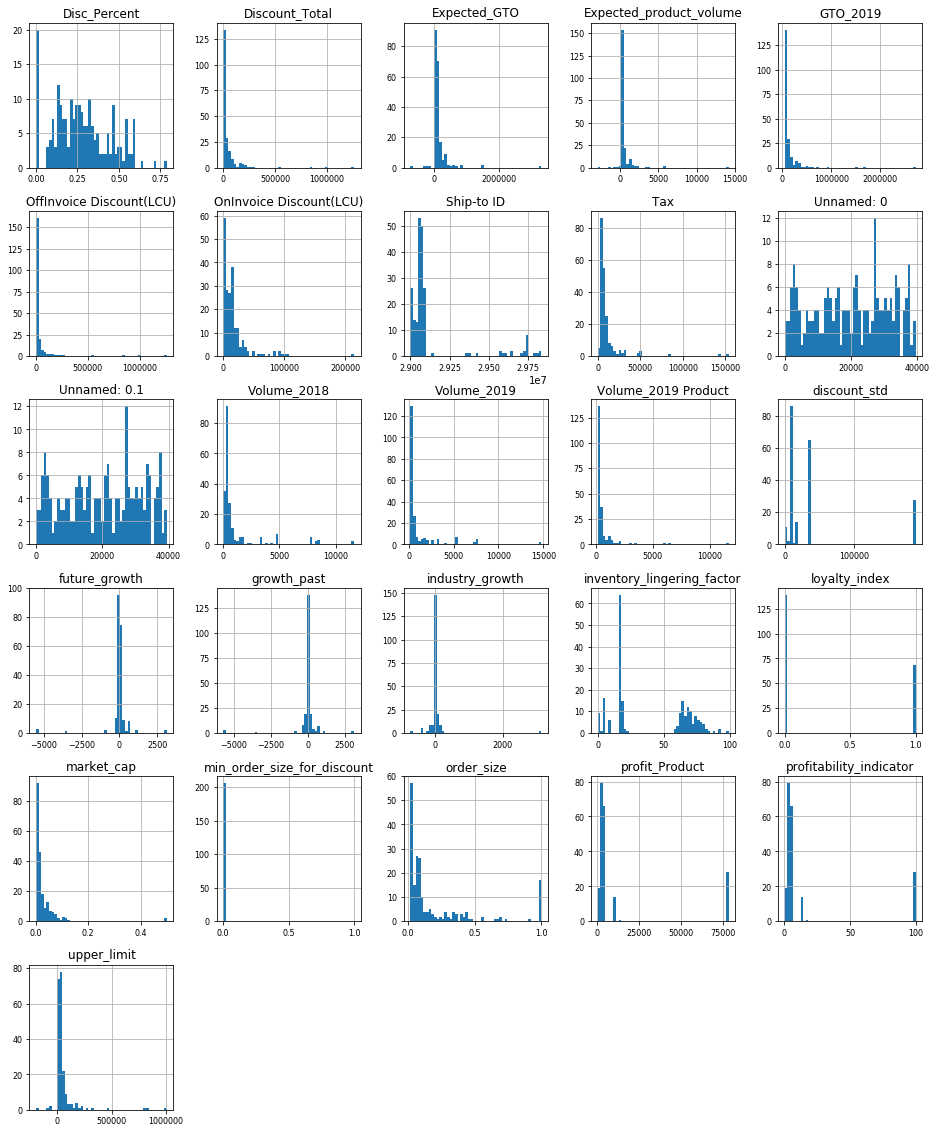

In [15]:
data2_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [16]:
data3 = df[df.GTO_2019<10000]
data3 = data3.reset_index()
data3 = data3.drop(["index"],axis=1)
data3_num =  data3.select_dtypes(include = ['float64', 'int64'])
data3_num.head()

,Unnamed: 0,Unnamed: 0.1,Ship-to ID,Volume_2019,Volume_2018,GTO_2019,OnInvoice Discount(LCU),OffInvoice Discount(LCU),Volume_2019 Product,Tax,...,Expected_GTO,Expected_product_volume,loyalty_index,min_order_size_for_discount,inventory_lingering_factor,profit_Product,profitability_indicator,discount_std,upper_limit,Disc_Percent
0,0,0,29000310,0.48,0.557,141.20,0.00,0.0,0.48,12.23,...,116.362876,0.395568,0,0.000059,0.030049,370.415207,0.474992,840.354946,30.119944,0.000000
1,1,1,29000419,0.45,0.540,113.65,0.00,0.0,0.45,7.85,...,88.943478,0.352174,0,0.002273,0.057372,207.180476,0.265672,421.813020,21.621963,0.000000
2,3,3,29000430,270.97,225.720,6001.00,1425.19,180.0,20.40,519.41,...,6955.593627,23.645077,1,0.000059,0.507591,370.415207,0.474992,840.354946,1800.544853,0.267487
3,4,4,29000430,270.97,225.720,3051.36,718.32,0.0,12.00,288.63,...,3536.747237,13.908869,0,0.000064,5.144873,3160.708348,4.053049,11271.537870,948.335452,0.235409
4,5,5,29000485,29.61,25.860,104.10,0.00,0.0,0.30,1.55,...,116.420237,0.335505,0,0.001134,0.101349,80.317475,0.102993,190.997870,34.290395,0.000000


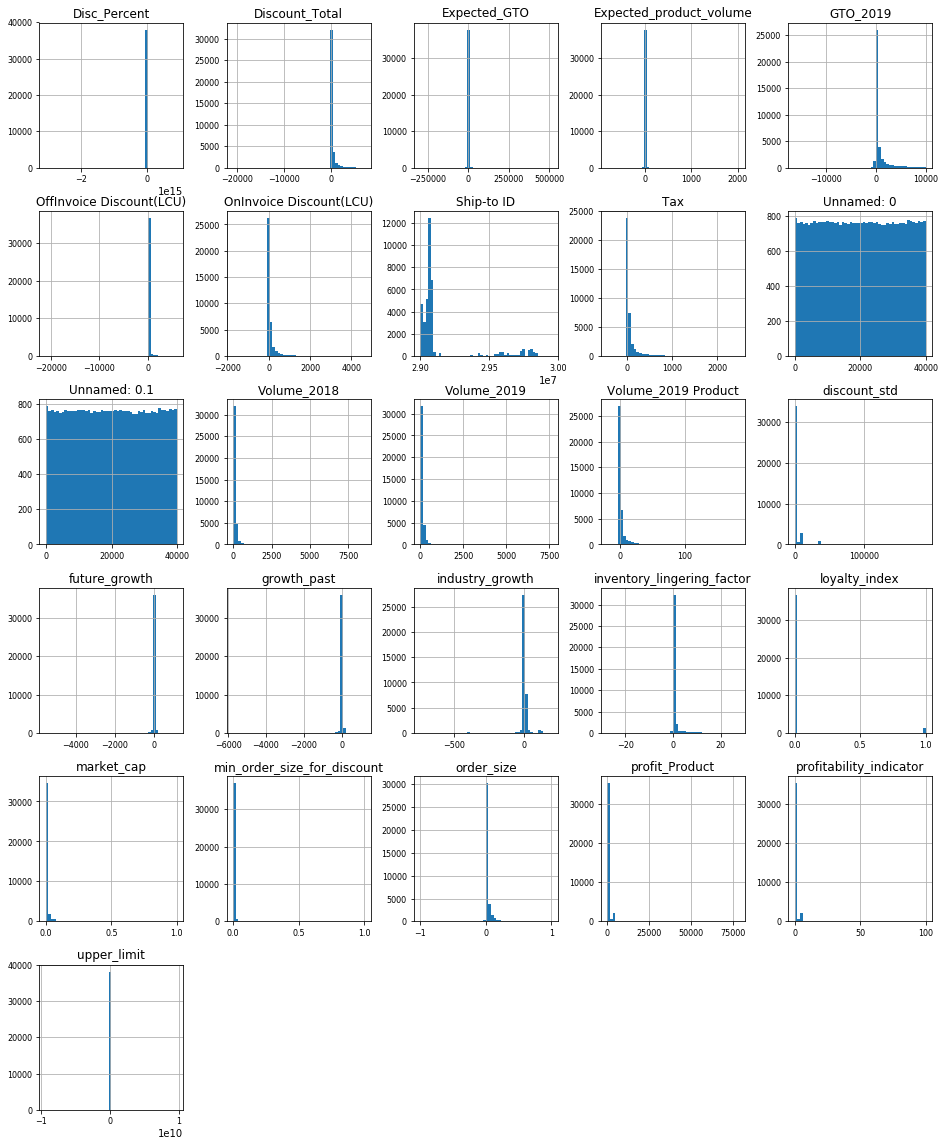

In [17]:
data3_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [19]:
corr_data = data2_num.drop(['Ship-to ID','growth_past','industry_growth','min_order_size_for_discount','profit_Product','discount_std','Disc_Percent','loyalty_index' ,'OnInvoice Discount(LCU)' , 'OffInvoice Discount(LCU)'],axis=1)
corr = corr_data.corr()
corr

,Unnamed: 0,Unnamed: 0.1,Volume_2019,Volume_2018,GTO_2019,Volume_2019 Product,Tax,Discount_Total,market_cap,future_growth,order_size,Expected_GTO,Expected_product_volume,inventory_lingering_factor,profitability_indicator,upper_limit
Unnamed: 0,1.000000,1.000000,-0.005867,-0.018855,-0.122020,-0.131682,-0.041117,-0.075742,-0.111714,0.030788,0.073118,-0.116223,-0.125725,-0.147254,-0.020616,-0.072498
Unnamed: 0.1,1.000000,1.000000,-0.005867,-0.018855,-0.122020,-0.131682,-0.041117,-0.075742,-0.111714,0.030788,0.073118,-0.116223,-0.125725,-0.147254,-0.020616,-0.072498
Volume_2019,-0.005867,-0.005867,1.000000,0.924714,0.677392,0.665810,0.359547,0.660997,0.592166,0.168834,0.631249,0.647884,0.637972,-0.044897,0.065571,0.612855
Volume_2018,-0.018855,-0.018855,0.924714,1.000000,0.606407,0.590447,0.397888,0.603649,0.469555,-0.219030,0.572561,0.479199,0.470825,-0.021327,0.099966,0.491418
GTO_2019,-0.122020,-0.122020,0.677392,0.606407,1.000000,0.996408,0.653607,0.973756,0.577659,0.167068,0.459733,0.950745,0.946811,0.213756,0.232417,0.949138
Volume_2019 Product,-0.131682,-0.131682,0.665810,0.590447,0.996408,1.000000,0.612155,0.961640,0.603788,0.179180,0.431420,0.952804,0.955818,0.217247,0.222897,0.937137
Tax,-0.041117,-0.041117,0.359547,0.397888,0.653607,0.612155,1.000000,0.698999,0.008031,-0.113323,0.391026,0.524789,0.486224,0.137243,0.295315,0.713758
Discount_Total,-0.075742,-0.075742,0.660997,0.603649,0.973756,0.961640,0.698999,1.000000,0.499679,0.131091,0.441509,0.910461,0.899288,0.214536,0.263074,0.952851
market_cap,-0.111714,-0.111714,0.592166,0.469555,0.577659,0.603788,0.008031,0.499679,1.000000,0.307645,0.307448,0.613076,0.637067,0.058932,0.116411,0.471841
future_growth,0.030788,0.030788,0.168834,-0.219030,0.167068,0.179180,-0.113323,0.131091,0.307645,1.000000,0.132813,0.421976,0.418679,-0.057617,-0.091448,0.298184


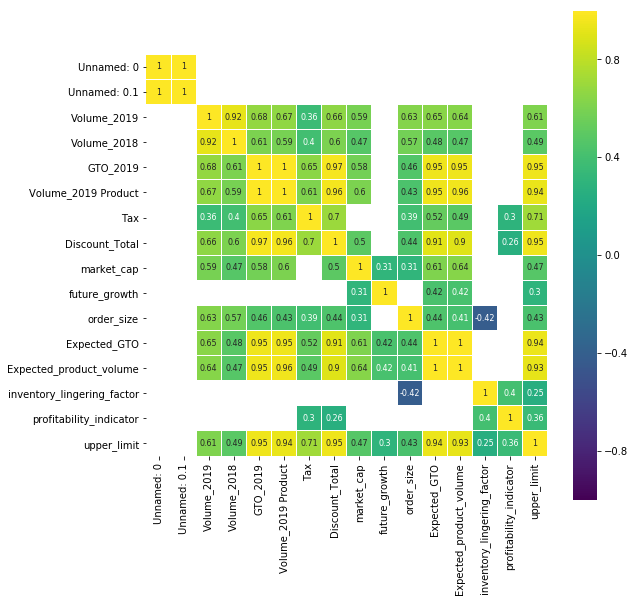

In [20]:
'''
Plotting the correlation heatmap for GTO>50k data
'''
plt.figure(figsize=(9, 9))
sns.heatmap(corr[(corr >= 0.25) | (corr <= -0.25)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [21]:
corr_data = data3_num.drop(['Ship-to ID','growth_past','industry_growth','min_order_size_for_discount','profit_Product','discount_std','Disc_Percent','OffInvoice Discount(LCU)','OnInvoice Discount(LCU)' ],axis=1)
corr = corr_data.corr()
corr

,Unnamed: 0,Unnamed: 0.1,Volume_2019,Volume_2018,GTO_2019,Volume_2019 Product,Tax,Discount_Total,market_cap,future_growth,order_size,Expected_GTO,Expected_product_volume,loyalty_index,inventory_lingering_factor,profitability_indicator,upper_limit
Unnamed: 0,1.000000,1.000000,-0.025197,-0.031915,0.004340,0.002792,0.001726,0.006214,0.035153,0.030470,0.002554,0.002398,0.003932,0.012908,-0.004617,0.017144,-0.002139
Unnamed: 0.1,1.000000,1.000000,-0.025197,-0.031915,0.004340,0.002792,0.001726,0.006214,0.035153,0.030470,0.002554,0.002398,0.003932,0.012908,-0.004617,0.017144,-0.002139
Volume_2019,-0.025197,-0.025197,1.000000,0.964926,0.087457,0.066092,0.077249,0.095276,0.073770,-0.052923,0.201707,0.042994,0.032923,0.128852,-0.007402,-0.020734,-0.000873
Volume_2018,-0.031915,-0.031915,0.964926,1.000000,0.079385,0.060993,0.068998,0.088277,0.072085,-0.313179,0.171673,0.017034,0.009571,0.127585,-0.006801,-0.016470,0.000915
GTO_2019,0.004340,0.004340,0.087457,0.079385,1.000000,0.946989,0.960868,0.757977,0.056405,0.014602,0.178905,0.388369,0.361589,0.092840,0.747698,0.394791,-0.000083
Volume_2019 Product,0.002792,0.002792,0.066092,0.060993,0.946989,1.000000,0.944812,0.688865,0.059097,0.006878,0.153887,0.362257,0.396075,0.087038,0.741646,0.423362,-0.000074
Tax,0.001726,0.001726,0.077249,0.068998,0.960868,0.944812,1.000000,0.663563,0.060176,0.016970,0.149582,0.370654,0.368178,0.086093,0.762163,0.409237,-0.000076
Discount_Total,0.006214,0.006214,0.095276,0.088277,0.757977,0.688865,0.663563,1.000000,0.048249,0.009284,0.144474,0.297974,0.262161,0.094508,0.521208,0.270238,-0.000069
market_cap,0.035153,0.035153,0.073770,0.072085,0.056405,0.059097,0.060176,0.048249,1.000000,-0.007422,0.040918,0.020991,0.023324,0.301592,0.037045,0.028619,-0.001570
future_growth,0.030470,0.030470,-0.052923,-0.313179,0.014602,0.006878,0.016970,0.009284,-0.007422,1.000000,0.077577,0.092120,0.083494,-0.019488,-0.001082,-0.012628,-0.006743


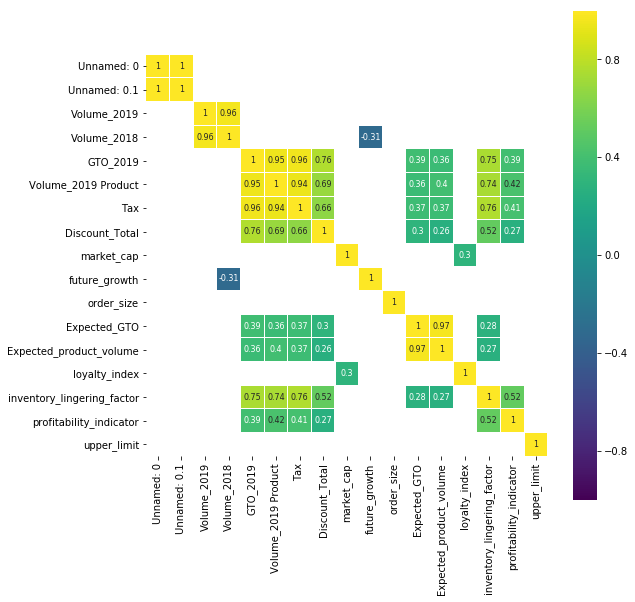

In [22]:
'''
Plotting the correlations for GTO<50k data
'''

plt.figure(figsize=(9, 9))
sns.heatmap(corr[(corr >= 0.25) | (corr <= -0.25)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [26]:

'''
Categorical analysis with Total Discount for GTO<50k data
Box Plots shows if the categories are able to seperate the Discounts well
For GTO<50k data , all categorical variables seem to be significant
For GTO>50k data , categorical variables are not good in seperating total Discounts well
'''
categorical_vars = ['sdfc_Tier','poc_image','Returnalility' , 'loyalty_index']
data2_cat = data2[categorical_vars]
data2_cat.head()

,sdfc_Tier,poc_image,Returnalility,loyalty_index
0,Tier 1,Mainstream,OW,1
1,Tier 2,Mainstream,RETURNABLE,1
2,Tier 2,Mainstream,RETURNABLE,0
3,Tier 1,Mainstream,RETURNABLE,1
4,Tier 1,Mainstream,RETURNABLE,1


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

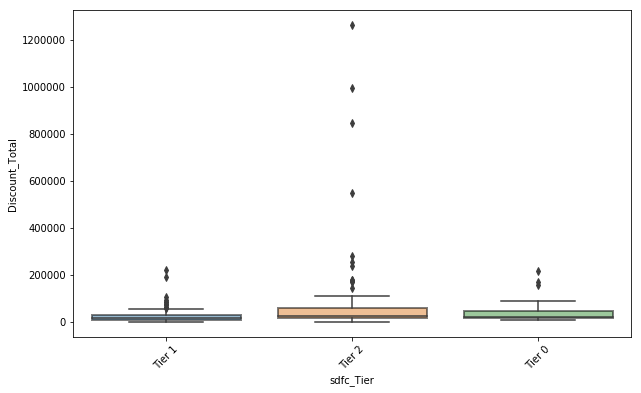

In [28]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='sdfc_Tier', y='Discount_Total', data=data2)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

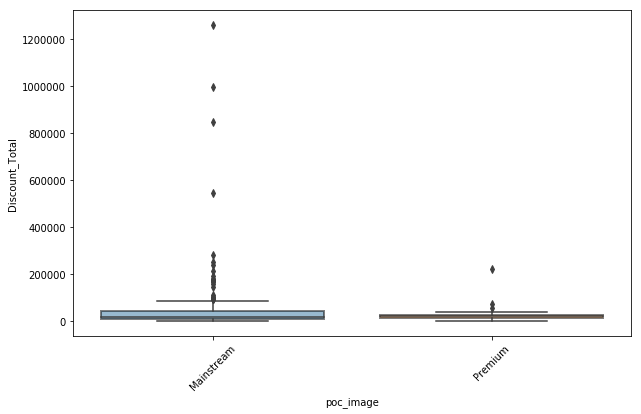

In [29]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='poc_image', y='Discount_Total', data=data2)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

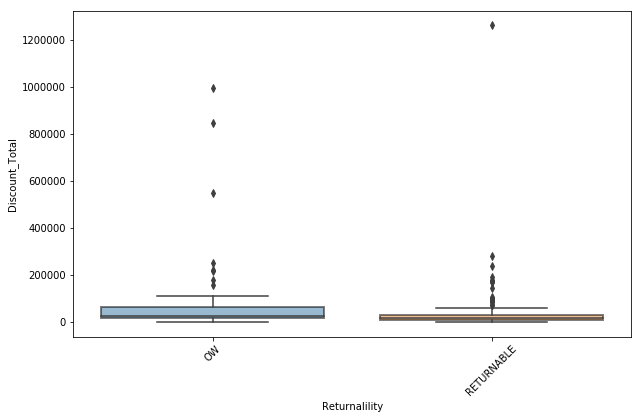

In [30]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='Returnalility', y='Discount_Total', data=data2)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

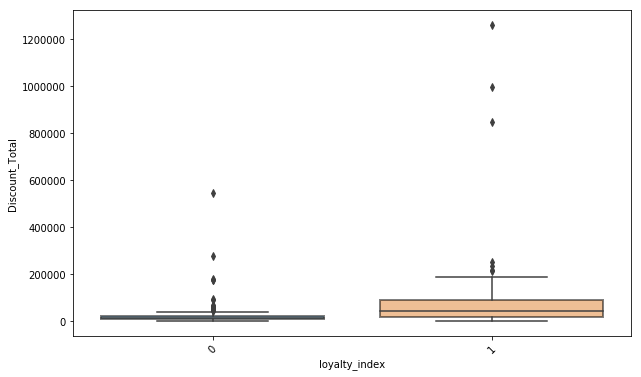

In [31]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='loyalty_index', y='Discount_Total', data=data2)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

# Statistical Testing

    1)p value & t tests : shows how significant is the independent variable & whether we can reject the null hypothesis
    
    2)p value < 0.05 : Reject null hypothesis i.e independent variable will have contribution in predicting dependent variable & it's coefficient won't be 0
    
    3)abs(r value)>5

In [33]:
corr_data.head()
corr_data = corr_data.drop(['Unnamed: 0','Discount_Total'],axis = 1)
corr_data.columns
cols = corr_data.columns

t_vals = list()
p_vals = list()
from scipy import stats
for i in range(len(cols)):
    t,p = stats.ttest_ind(data2_num[cols[i]],data2_num['Discount_Total'])
    t_vals.append(abs(round(t,5)))
    p_vals.append(round(p,5))
    
test_df = pd.DataFrame(t_vals , columns = ["t_Value"])
test_df['cols'] = cols
test_df['p_Value'] = p_vals

test_df = test_df.set_index(cols)
test_df = test_df.drop(['cols'],axis=1)
test_df

,t_Value,p_Value
Unnamed: 0.1,3.45163,0.00061
Volume_2019,5.47931,0.00000
Volume_2018,5.47704,0.00000
GTO_2019,4.50546,0.00001
Volume_2019 Product,5.54606,0.00000
Tax,4.36450,0.00002
market_cap,5.60574,0.00000
future_growth,5.60767,0.00000
order_size,5.60572,0.00000
Expected_GTO,4.02897,0.00007


In [34]:
cols = corr_data.columns

t_vals = list()
p_vals = list()
from scipy import stats
for i in range(len(cols)):
    t,p = stats.ttest_ind(data3_num[cols[i]],data3_num['Discount_Total'])
    t_vals.append(abs(round(t,5)))
    p_vals.append(round(p,5))
test_df_2 = pd.DataFrame(t_vals , columns = ["t_Value"])
test_df_2['cols'] = cols
test_df_2['p_Value'] = p_vals
test_df_2 = test_df_2.set_index(cols)
test_df_2 = test_df_2.drop(['cols'],axis=1)
test_df_2

,t_Value,p_Value
Unnamed: 0.1,333.82834,0.00000
Volume_2019,19.88985,0.00000
Volume_2018,19.76014,0.00000
GTO_2019,72.86926,0.00000
Volume_2019 Product,67.29993,0.00000
Tax,41.65204,0.00000
market_cap,68.28267,0.00000
future_growth,66.80988,0.00000
order_size,68.27273,0.00000
Expected_GTO,26.99366,0.00000
